In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install scikit-optimize

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.8/107.8 kB 2.0 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, Matern, RationalQuadratic, ExpSineSquared, DotProduct, ConstantKernel, WhiteKernel
from statsmodels.stats.outliers_influence import variance_inflation_factor
from skopt import BayesSearchCV
import joblib
from statsmodels.tsa.stattools import adfuller, kpss
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
df = pd.read_excel('/content/drive/MyDrive/forecasting akhir yoy kmk.xlsx')
df = df.iloc[24:-1]
target = 'YOY_KMK'
df.reset_index(drop=True, inplace=True)

# Feature Engineering

Prediksi t-bulan kedepan

In [ ]:
t = 6

In [ ]:
data = df.dropna()
data['date'] = data['PERIOD'].astype(str).str[:4] +'-'+data['PERIOD'].astype(str).str[-2:]+'-01' #string format
data['date'] = pd.to_datetime(data['date'], format='%Y-%m-%d') #parse to date format
data = data.drop('PERIOD',axis=1)
data.reset_index(drop=True, inplace=True)
data.set_index('date',inplace=True)
data.index = data.index + pd.DateOffset(months=t)

Interpolating quarterly data into monthly



In [ ]:
def interpolate_quarterly_data(data, column_names):
    for column_name in column_names:
        # Access the month from the datetime index using .name
        data[column_name] = data.apply(
            lambda x: x[column_name] if x.name.month in [1, 4, 7, 10] else None, axis=1
        )
        data[column_name] = data[column_name].interpolate(method='linear')
    return data

In [ ]:
data = interpolate_quarterly_data(data, ['YOY_CAPEX','YOY_NFA','YOY_SALES','MEDIAN_ICR','YOY_DEBT','YOY_CA','ROA','ROE','YOY_PDB']).dropna()

Implementing lag

In [ ]:
for lag in [1,2,3,4,5,6]:
  data[f'{target}_lag_{lag}'] = data[target].shift(lag)

Implementing window rolling

In [ ]:
window = 3
data[f'rolling_mean_{window}'] = data[target].rolling(window=window).mean()
data[f'rolling_std_{window}'] = data[target].rolling(window=window).std()

In [ ]:
data['expanding_mean'] = data[target].expanding(1).mean()
data['expanding_std'] = data[target].expanding(1).std()

Implementing seasonal differencing

In [ ]:
data['diff_1'] = data[target].diff(1)
data['diff_12'] = data[target].diff(12)

Seasonal Decomposing

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose

result = seasonal_decompose(data[target], model='additive', period=12, extrapolate_trend='freq')
data['trend'] = result.trend
data['seasonal'] = result.seasonal
data['residual'] = result.resid

Fourier transformation as feature

In [ ]:
def create_fourier_features(data, freq, K):
    t = np.arange(len(data))
    for k in range(1, K+1):
        data[f'sin_{freq}_{k}'] = np.sin(2 * np.pi * k * t / freq)
        data[f'cos_{freq}_{k}'] = np.cos(2 * np.pi * k * t / freq)

create_fourier_features(data, freq=12, K=3)

In [ ]:
data = data.dropna()

# Train Model Here

In [ ]:
features = data.columns.difference([target, 'date'])

In [ ]:
X = data[features]
y = data[target]
X_forecast = X[-t:]
X = X[:-t]
y = y.shift(-t).dropna()

In [ ]:
from sklearn.feature_selection import SelectKBest, f_regression
selector = SelectKBest(score_func=f_regression, k=10)
X_new = selector.fit_transform(X, y)
selected_features = X.columns[selector.get_support()]

In [ ]:
selected_features

Index(['MEDIAN_ICR', 'ROA', 'ROE', 'YOY_CA', 'YOY_KMK_lag_1', 'YOY_KMK_lag_2',
       'YOY_PDB', 'YOY_SALES', 'rolling_mean_3', 'trend'],
      dtype='object')

In [ ]:
X = X[selected_features]

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
!pip install lazypredict

In [ ]:
from lazypredict.Supervised import LazyRegressor
lazy_reg = LazyRegressor(verbose=0, ignore_warnings=True, custom_metric=None)
models, predictions = lazy_reg.fit(X_train, X_test, y_train, y_test)

100%|██████████| 42/42 [00:05<00:00,  7.04it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000181 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 350
[LightGBM] [Info] Number of data points in the train set: 100, number of used features: 10
[LightGBM] [Info] Start training from score 12.847008
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

In [ ]:
print(models)

                               Adjusted R-Squared  R-Squared  RMSE  Time Taken
Model                                                                         
AdaBoostRegressor                           -0.07       0.36  3.04        0.17
SVR                                         -0.18       0.29  3.19        0.01
NuSVR                                       -0.36       0.18  3.44        0.05
HistGradientBoostingRegressor               -0.51       0.09  3.62        0.90
XGBRegressor                                -0.58       0.05  3.70        1.28
DummyRegressor                              -0.74      -0.04  3.88        0.02
RandomForestRegressor                       -0.74      -0.05  3.89        0.47
KNeighborsRegressor                         -0.97      -0.18  4.13        0.02
ExtraTreesRegressor                         -1.04      -0.22  4.20        0.25
TweedieRegressor                            -1.16      -0.30  4.33        0.34
ElasticNet                                  -1.26   

In [ ]:
from sklearn.ensemble import AdaBoostRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score, mean_squared_error

# Define the parameter grid for AdaBoostRegressor
param_grid_adaboost = {
    'n_estimators': [50, 100, 200],            # Number of estimators (trees)
    'learning_rate': [0.01, 0.1, 1.0],         # Learning rate
    'loss': ['linear', 'square', 'exponential']  # Loss function to use
}

# Perform Grid Search with Cross-Validation
grid_search_adaboost = GridSearchCV(estimator=AdaBoostRegressor(), param_grid=param_grid_adaboost, cv=3, scoring='r2', verbose=1)
grid_search_adaboost.fit(X_train, y_train)

# Print the best parameters found by Grid Search
print("Best parameters found by Grid Search for AdaBoostRegressor:", grid_search_adaboost.best_params_)

# Train the final model using the best parameters from Grid Search
final_model_adaboost_grid = AdaBoostRegressor(**grid_search_adaboost.best_params_)
final_model_adaboost_grid.fit(X_train, y_train)

# Make predictions
y_pred_adaboost_grid = final_model_adaboost_grid.predict(X_test)

# Evaluate the refined model
r2_adaboost_grid = r2_score(y_test, y_pred_adaboost_grid)
mse_adaboost_grid = mean_squared_error(y_test, y_pred_adaboost_grid)
print(f'R^2 Score for AdaBoostRegressor with Grid Search: {r2_adaboost_grid}')
print(f'Mean Squared Error for AdaBoostRegressor with Grid Search: {mse_adaboost_grid}')

Fitting 3 folds for each of 27 candidates, totalling 81 fits
Best parameters found by Grid Search for AdaBoostRegressor: {'learning_rate': 0.01, 'loss': 'linear', 'n_estimators': 100}
R^2 Score for AdaBoostRegressor with Grid Search: 0.1944781366111592
Mean Squared Error for AdaBoostRegressor with Grid Search: 11.62135370596788


In [ ]:
print(f'Root Mean Squared Error for SVR with Grid Search: {np.sqrt(mse_adaboost_grid)}')

Root Mean Squared Error for SVR with Grid Search: 3.409010663809646


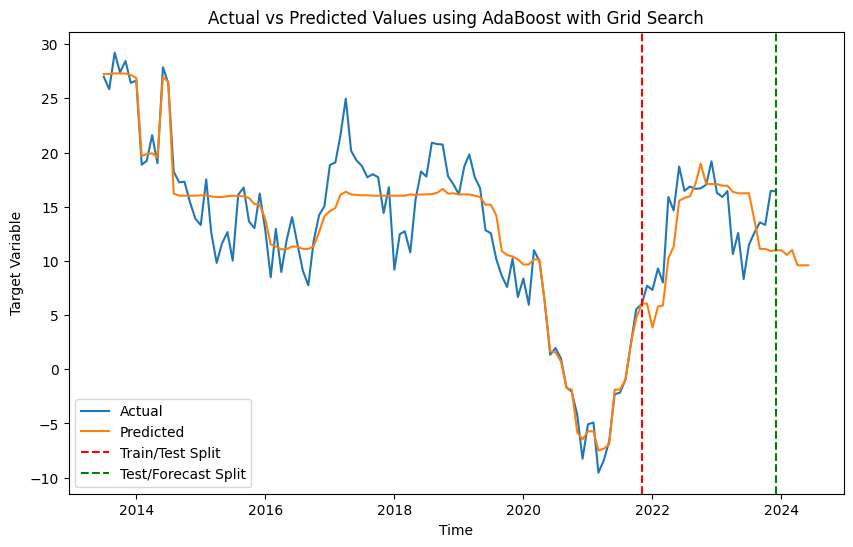

In [ ]:
# prompt: plot Y and predicted Y using final_model_etr_grid model

import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))

# Plot the actual values
plt.plot(data.index[:-6], y.to_numpy().reshape(-1, 1), label="Actual")
# Plot the predicted values
y_predicted = final_model_adaboost_grid.predict(scaler.transform(X))
y_forecast = final_model_adaboost_grid.predict(scaler.transform(X_forecast[selected_features]))
plt.plot(data.index, np.concatenate((y_predicted, y_forecast)), label="Predicted")
plt.axvline(x=data.index[len(y_train)], color='r', linestyle='--', label='Train/Test Split')
plt.axvline(x=data.index[len(y_train) + len(y_test)-1], color='g', linestyle='--', label='Test/Forecast Split')
# Add labels and title
plt.xlabel("Time")
plt.ylabel("Target Variable")
plt.title("Actual vs Predicted Values using AdaBoost with Grid Search")

# Add legend and show the plot
plt.legend()
plt.show()


In [ ]:
!pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.5/540.5 kB 8.7 MB/s eta 0:00:00


  0%|          | 0/26 [00:00<?, ?it/s]

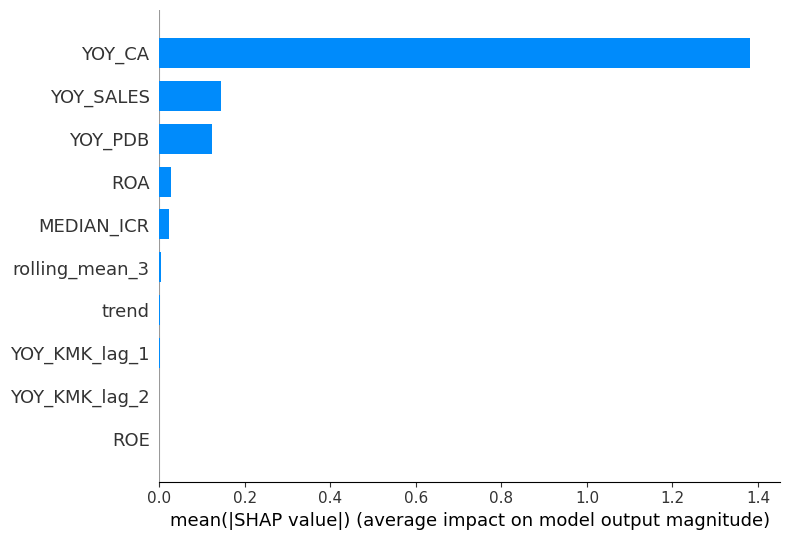

In [ ]:
import shap

# Create a Shap explainer
explainer = shap.KernelExplainer(final_model_adaboost_grid.predict, scaler.transform(X_train))

# Calculate Shap values for X_test
shap_values = explainer.shap_values(scaler.transform(X_test))

# Plot the Shap feature importance
shap.summary_plot(shap_values, X_test, plot_type="bar", feature_names=X.columns)
